## TensorFlow Head Pose Model
Source: [here](https://towardsdatascience.com/multitask-learning-in-tensorflow-with-the-head-api-68f2717019df)

## Set up the virtual machine

In [1]:
# Install all necessary packages
!pip install tensorflow tqdm requests --upgrade

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (1.13.1)
    100% |████████████████████████████████| 51kB 3.5MB/s 
    100% |████████████████████████████████| 61kB 21.8MB/s 
spacy 2.0.18 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
google-colab 1.0.0 has requirement requests~=2.18.0, but you'll have requests 2.21.0 which is incompatible.
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
fastai 1.0.46 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1
  Found existing installation: requests 2.18.4
    Uninstalling requests-2.18.4:
      Successfully uninstalled requests-2.18.4


In [1]:
# Dataset is taken from here: http://mmlab.ie.cuhk.edu.hk/projects/TCDCN.html
# Small code is taken from this StackOverflow thread: https://stackoverflow.com/questions/22676/how-do-i-download-a-file-over-http-using-python
# This could take a while!

from tqdm import tqdm
import requests

url = "http://mmlab.ie.cuhk.edu.hk/projects/TCDCN/data/MTFL.zip"
response = requests.get(url, stream=True)

with open("MTFL", "wb") as handle:
    for data in tqdm(response.iter_content(), unit=' KB'):
        handle.write(data)

150152960 KB [23:51, 104894.78 KB/s]


In [0]:
# Unzip all files
import zipfile
zip_ref = zipfile.ZipFile('MTFL', 'r')
zip_ref.extractall()
zip_ref.close()

In [3]:
# Check data has been downloaded
!ls

AFLW	  MTFL	    readme.txt	 testing.txt
lfw_5590  net_7876  sample_data  training.txt


## Load Data

In [0]:
# Import training/test files in Pandas
import pandas as pd
train_data = pd.read_csv('training.txt', sep=' ', header=None, skipinitialspace=True, nrows=10000)
test_data = pd.read_csv('testing.txt', sep=' ', header=None, skipinitialspace=True, nrows=2995)

In [5]:
# Inspect the first row
train_data.iloc[0]

0     lfw_5590\Aaron_Eckhart_0001.jpg
1                              107.25
2                              147.75
3                              126.25
4                              106.25
5                              140.75
6                              108.75
7                              113.25
8                              143.75
9                              158.75
10                             162.75
11                                  1
12                                  2
13                                  2
14                                  3
Name: 0, dtype: object

In [0]:
# Simple hack to replace \ with /
train_data.iloc[:, 0] = train_data.iloc[:, 0].apply(lambda s: s.replace('\\', '/')) # Needed for filename convention
test_data.iloc[:, 0] = test_data.iloc[:, 0].apply(lambda s: s.replace('\\', '/')) # Needed for filename convention

## Step 1 - Data loading with tf.data and tf.image

In [0]:
# Note: we are enabling eager execution for debugging!
import numpy as np
import tensorflow as tf
tf.enable_eager_execution()

In [8]:
# Example code for handling datasets
import matplotlib.pyplot as plt

# Load filenames and labels
filenames = tf.constant(train_data.iloc[:, 0].tolist())
labels = tf.constant(train_data.iloc[:, 1:].values)

# Add to a dataset object
dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

# We can debug using eager execution
for img, labels in dataset.batch(4).take(1):
  print(img)
  print(labels)

Instructions for updating:
Colocations handled automatically by placer.
tf.Tensor(
[b'lfw_5590/Aaron_Eckhart_0001.jpg' b'lfw_5590/Aaron_Guiel_0001.jpg'
 b'lfw_5590/Aaron_Peirsol_0001.jpg' b'lfw_5590/Aaron_Pena_0001.jpg'], shape=(4,), dtype=string)
tf.Tensor(
[[107.25 147.75 126.25 106.25 140.75 108.75 113.25 143.75 158.75 162.75
    1.     2.     2.     3.  ]
 [101.25 146.75 125.25  93.75 139.75 112.25 117.75 137.75 160.75 164.75
    1.     1.     2.     3.  ]
 [107.75 147.75 130.25 109.25 147.75 114.25 114.25 140.75 154.25 153.75
    1.     1.     2.     3.  ]
 [102.75 146.25 126.25 120.75 147.25 117.75 104.75 137.75 164.75 156.75
    1.     2.     2.     3.  ]], shape=(4, 14), dtype=float64)


In [0]:
# Reads an image from a file, decodes it into a dense tensor, and resizes it
# to a fixed shape.
def _parse_function(filename, label):
  image_string = tf.read_file(filename) 
  image_decoded = tf.image.decode_jpeg(image_string, channels=3) # Channels needed because some test images are b/w
  image_resized = tf.image.resize_images(image_decoded, [40, 40])
  image_shape = tf.cast(tf.shape(image_decoded), tf.float32)
  label = tf.concat([label[0:5] / image_shape[0], label[5:10] / image_shape[1], label[10:]], axis=0)
  return {"x": image_resized}, label

In [0]:
# This snippet is adapted from here: https://www.tensorflow.org/guide/datasets
def input_fn(dataframe, is_eval=False):

  # Load the list of files
  filenames = tf.constant(dataframe.iloc[:, 0].tolist())

  # Load the labels
  labels = tf.constant(dataframe.iloc[:, 1:].values.astype(np.float32))

  # Build the dataset with image processing on top of it
  dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
  dataset = dataset.map(_parse_function)

  # Add shuffling and repeatition if training
  if is_eval:
    dataset = dataset.batch(64)
  else:
    dataset = dataset.repeat().shuffle(1000).batch(64)
  
  return dataset

tf.Tensor(
[0.429 0.591 0.505 0.425 0.563 0.435 0.453 0.575 0.635 0.651 1.    2.
 2.    3.   ], shape=(14,), dtype=float32)


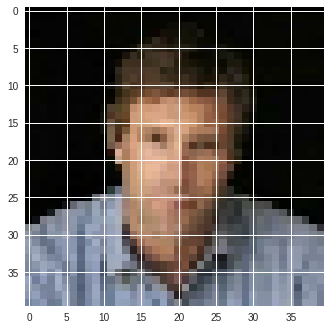

In [11]:
# Check the image
import matplotlib.pyplot as plt
for (imgs, labels) in input_fn(train_data, is_eval=True).take(1):
  plt.imshow(imgs['x'][0] / 255)
  print(labels[0])

## Standard classical estimator (single-task only!)

In [0]:
# Reimplement the feature extraction from the original paper
def extract_features(features):
  # Input layer
  input_layer = tf.reshape(features["x"], [-1, 40, 40, 3])

  # First convolutive layer
  conv1 = tf.layers.conv2d(inputs=input_layer, filters=16, kernel_size=[5, 5], padding="same", activation=tf.nn.relu)
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  # Second convolutive layer
  conv2 = tf.layers.conv2d(inputs=pool1, filters=48, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
  
  # Third convolutive layer
  conv3 = tf.layers.conv2d(inputs=pool2, filters=64, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
  pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)
  
  # Fourth convolutive layer
  conv4 = tf.layers.conv2d(inputs=pool3, filters=64, kernel_size=[2, 2], padding="same", activation=tf.nn.relu)
  
  # Dense Layer
  flat = tf.reshape(conv4, [-1, 5 * 5 * 64])
  dense = tf.layers.dense(inputs=flat, units=100, activation=tf.nn.relu)
  
  return dense

In [0]:
# Adapted from here: https://www.tensorflow.org/tutorials/layers
def single_task_cnn_model_fn(features, labels, mode):
  
  # Get features
  dense = extract_features(features)
  
  # Make predictions
  predictions = tf.layers.dense(inputs=dense, units=2)

  outputs = {
      "predictions": predictions
  }

  # We just want the predictions
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=outputs)

  # If not in mode.PREDICT, compute the loss (mean squared error)
  loss = tf.losses.mean_squared_error(labels=labels[:, 2:8:5], predictions=predictions)

  # Single optimization step
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.AdamOptimizer()
    train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # If not PREDICT or TRAIN, then we are evaluating the model
  eval_metric_ops = {
      "rmse": tf.metrics.root_mean_squared_error(
          labels=labels[:, 2:8:5], predictions=outputs["predictions"])}
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)